### topic modeling
https://github.com/MaartenGr/BERTopic/pull/840

## Objective:
In the process of developing a different data science project, I came across an anomoly that I want to further investigate. To this end, the objective of this notebook is to pinpoint the anomaly, identify topics, and point out key differences in the text vs the anomalous text using BERT topic modeling as well as vector differences (using differnet embeddings as vectors for various n-gram and sentence groups).

In [4]:
# imports
# check imports later
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import pickle
import emoji
import unidecode
from html import unescape
from bs4 import BeautifulSoup
import warnings
import html
warnings.filterwarnings('ignore')

# pd.set_option('display.html.use_mathjax', False) # normalize fonts for pandas display
pd.options.display.max_colwidth = None

# custom functions 
# Fix this later
from utils import save_fig, make_timestamp, populate_pos_class, find_best_score

In [5]:
# extract and examine the first ten rows of the data
df = pd.read_csv('https://query.data.world/s/htrdsouy327xqa4w457qx6k6sjtj6r')
df.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i/i_am_soooo_glad_im_not_circumcised/,self.jokes,NaN,My corona is covered with foreskin so it is not exposed to viruses.,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup/did_you_know_google_now_has_a_platform_for/,self.jokes,NaN,It's called Google Sheets.,Did you know Google now has a platform for recording your bowel movements?,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj/what_is_the_difference_between_my_wife_and_my/,self.jokes,NaN,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",What is the difference between my wife and my vacuum?,15
3,post,ftbnxh,2qh72,jokes,False,1585785428,https://old.reddit.com/r/Jokes/comments/ftbnxh/my_last_joke_for_now/,self.jokes,NaN,[removed],My last joke for now.,9
4,post,ftbjpg,2qh72,jokes,False,1585785009,https://old.reddit.com/r/Jokes/comments/ftbjpg/the_nintendo_64_turns_18_this_week/,self.jokes,NaN,[removed],The Nintendo 64 turns 18 this week...,134


In [6]:
# dataframe dimensions
df.shape

(1000000, 12)

In [7]:
# look at the text information and the reddit score
df[['title', 'selftext', 'score']].head(10)

,title,selftext,score
0,I am soooo glad I'm not circumcised!,My corona is covered with foreskin so it is not exposed to viruses.,2
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.,9
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife.",15
3,My last joke for now.,[removed],9
4,The Nintendo 64 turns 18 this week...,[removed],134
5,Sex with teacher.,[removed],1
6,Another long one.,[removed],8
7,What did the French man say to the attractive teletubby?,Oo..lala...,2
8,A Priest takes a walk down to the docks one day,[removed],88
9,A long joke.,[removed],4


In [8]:
# description of score feature
df['score'].describe()

count    1000000.000000
mean         139.691119
std         1674.046005
min            0.000000
25%            0.000000
50%            1.000000
75%            7.000000
max       142733.000000
Name: score, dtype: float64

Saving figure scores distribution


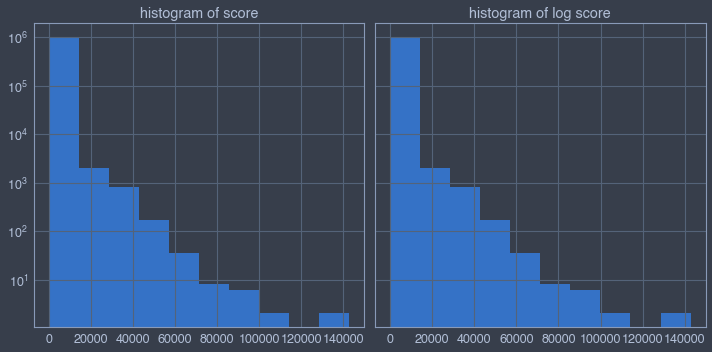

In [34]:
# score feature distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, tight_layout=True)

axes[0].hist(df['score'])
axes[0].set_title('histogram of score')

axes[1].hist(df['score'], log=True)
axes[1].set_title('histogram of log score')

save_fig('scores distribution')

In [10]:
# some useful descriptions of the title and selftext string lengths
df[['title','selftext']].applymap(lambda x: len(str(x))).agg(['mean', 'std', 'median', 'min', 'max']).add_suffix('_length')

,title_length,selftext_length
mean,48.471865,104.017822
std,27.835295,359.563590
median,44.000000,14.000000
min,1.000000,1.000000
max,311.000000,40000.000000


In [11]:
# define some parameters to refine the conditions for extracting data from the dataset to create a binary classification dataset

# the desired number of samples per class (positive class)
CLASS_SIZE = 100000

# the percentage of total data set to allocate for training
TRAIN_SIZE = 0.99

# score floor and ceiling, resp. when allocating instances to the positive class
MIN_UPVOTES = 10
MAX_UPVOTES = df['score'].max()

# string max lengths for the post title and selftext 
TITLE_MAX_LEN = 150
SELFTEXT_MAX_LEN = 500

In [12]:
# some helpful boolean masks
is_null = df['selftext'].isnull() # where selftext isnull (no punchline)

# where title or post were removed by reddit user/mod
removed = (df['selftext'].str.contains(r"(?i)[^a-z\s]removed[^a-z\s]", regex=True)) | (df['title'].str.contains(r"(?i)[^a-z\s]removed[^a-z\s]", regex=True)) 

# where tile or post were deleted by the original poster
deleted = (df['selftext'].str.contains(r"(?i)[^a-z\s]deleted[^a-z\s]", regex=True)) | (df['title'].str.contains(r"(?i)[^a-z\s]deleted[^a-z\s]", regex=True)) 

# reposts or duplicates
duplicated = df.duplicated(subset=['title', 'selftext'], keep='first')

# where upvotes is 0 (reddit automatically provides user 1 upvote)
neg_class = df['score'] == 0

### Cleaning

In [13]:
# get entries that aren't removed or deleted
df_cleaned = df[~removed][~deleted][~duplicated].copy()
df_cleaned.shape

(565332, 12)

In [14]:
print("what are NaNs?")
display(df_cleaned[df_cleaned['score'] > 2000][is_null][['title', 'selftext', 'score']].head(10))
df_cleaned = df_cleaned[~is_null]

what are NaNs?


,title,selftext,score
308797,What happens when you cross a joke with a rhetorical question?,NaN,3938
625315,The funniest /r/jokes has ever been,NaN,67950
914649,Shout out to people who don't know the opposite of in,NaN,4580
915783,5 out of 6 scientists say Russian Roulette is safe.,NaN,10085
919422,"Accordion to a recent survey, replacing words with the names of musical instruments in a sentence often goes undetected.",NaN,12580
927114,"Never make fun of a fat girl with a lisp, she's probably thick and tired of it.",NaN,7848
931755,"6:30 is the best time on a clock, hands down.",NaN,2173
933895,"Bruce Jenner winning woman of the year just proves that men are better than women at everything, including being a woman",NaN,11999
935376,"I often say to myself, ""I can't believe that cloning machine worked.""",NaN,6524
937567,How Long is a Chinese name.,NaN,2404


In [15]:
# removing escape character references  
escapes = ''.join([chr(char) for char in range(1,32)]) # converting integer to characters

print("the output of printing escape characters: ", escapes)
print(escapes)
print("the output of displaying escape characters: ")
display(escapes)

the output of printing escape characters:  	

	

the output of displaying escape characters: 


'\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f'

In [16]:
# remove the escape characters
# get examples of instances containing pattern
print("samples instances containing pattern :")
escapes_idx = df_cleaned[df_cleaned['selftext'].str.contains("|".join(escapes))].index
display(df_cleaned.loc[escapes_idx][['title', 'selftext']].head())

df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(str(x).translate(escapes)).split()))
display(df_cleaned[['title', 'selftext']].loc[escapes_idx].head())

samples instances containing pattern :


,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex.\n\n&amp;#x200B;\n\nApril fools, I don't have a wife."
21,Husband: I cheated on you once,Wife: well if we are coming clean I cheated on you too\n\nHusband: haha April First!\n\nWife: it was May 17\n\nE: grammar
27,"Tee Pee a House on, April Fool's, 2020","Wouldn’t today, April Fool’s Day, 2020, be the best time to TeePee someone’s house?\n\nThe neighborhood will clean it up in four minutes."
30,Two guys are caught by cannibals,"They are sitting in the big pot as the cannibals are stoking the fire, adding water, potatoes, and other veggies. One of the men starts laughing. \n\n“His friend says what is the matter with you we are about to be turned into stew and your laughing. “\n\n“I just shit in the gravy!”\n\nThen the cannibals grant them three wishes and it turns into a different joke."
40,A very rich man was infatuated with General Custer...,"So he hired the world’s most famous painter to paint him a piece for the rich man’s 50th birthday. The piece was to represent General Custer’s last thoughts. The painter said of course I will do this, but no one can see the painting until the reveal at your party. The rich man agreed knowing the prestige of the painter.\n\nThe day of the party comes, and the rich man gathered every one of his friends for the reveal. The painter asks if every one was ready, and the rich man happily screams, “Of course! I’ve been waiting for months!” \n\nThe curtain over the painting drops, and the entire painting is covered in Native Americans having sex. There is even multiple orgies happening! \n\nThe rich man runs to painter furious screaming, “I told you to paint General Custer’s last thoughts!” The painter, deadpan, responds, “I did exactly as you requested!” The rich man says, “What was your thinking in Custer’s last thoughts then?” The painter simply reply’s, \n\n“Look at all those fucking Indians!”"


,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. &amp;#x200B; April fools, I don't have a wife."
21,Husband: I cheated on you once,Wife: well if we are coming clean I cheated on you too Husband: haha April First! Wife: it was May 17 E: grammar
27,"Tee Pee a House on, April Fool's, 2020","Wouldn’t today, April Fool’s Day, 2020, be the best time to TeePee someone’s house? The neighborhood will clean it up in four minutes."
30,Two guys are caught by cannibals,"They are sitting in the big pot as the cannibals are stoking the fire, adding water, potatoes, and other veggies. One of the men starts laughing. “His friend says what is the matter with you we are about to be turned into stew and your laughing. “ “I just shit in the gravy!” Then the cannibals grant them three wishes and it turns into a different joke."
40,A very rich man was infatuated with General Custer...,"So he hired the world’s most famous painter to paint him a piece for the rich man’s 50th birthday. The piece was to represent General Custer’s last thoughts. The painter said of course I will do this, but no one can see the painting until the reveal at your party. The rich man agreed knowing the prestige of the painter. The day of the party comes, and the rich man gathered every one of his friends for the reveal. The painter asks if every one was ready, and the rich man happily screams, “Of course! I’ve been waiting for months!” The curtain over the painting drops, and the entire painting is covered in Native Americans having sex. There is even multiple orgies happening! The rich man runs to painter furious screaming, “I told you to paint General Custer’s last thoughts!” The painter, deadpan, responds, “I did exactly as you requested!” The rich man says, “What was your thinking in Custer’s last thoughts then?” The painter simply reply’s, “Look at all those fucking Indians!”"


In [17]:
# removing html character references  
PATTERN = r"[^a-z\s]?(&\S+;)[^a-z\s]?"

# get examples of instances containing pattern
print("samples instances containing pattern :")
html_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[html_idx][['title', 'selftext']].head())

# see changes
print("transformed instances :")
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: re.sub(PATTERN, " ", str(x)))
display(df_cleaned.loc[html_idx][['title', 'selftext']].head())

samples instances containing pattern :


,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. &amp;#x200B; April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. &amp;#x200B; ""Many moons pass, and chief Walking Horse no go number two."" He complains. &amp;#x200B; The doctor reaches into his cabinet and fishes out a mild laxative. &amp;#x200B; ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" &amp;#x200B; The chief took the little bottle, and left back to his village. &amp;#x200B; Two days later, ask the Doctor requested, he's back. &amp;#x200B; ""Chief Walking Horse, have you moved yet?"" &amp;#x200B; The chief slowly shakes his head no. &amp;#x200B; ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" &amp;#x200B; The chief nods his head yes, and leaves to return to his village. &amp;#x200B; This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. &amp;#x200B; A few days later, while visiting a close by settlement, the Doctor sees the Chief. &amp;#x200B; ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" &amp;#x200B; The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
464,How do you waste people's time?,&gt;!not like this !&lt;/ &gt;! not like this not like this !&lt;/&gt;! / not like this!&lt; &amp;#x200B; &gt;!not like this tooo!&lt; .&gt;!not like this also !&lt;&gt;!look somewhere else!&lt; &amp;#x200B; &gt;!Not like this either !&lt; . &gt;! not like this !&lt;.&gt;! not like this!&lt;
532,I touched my girlfriends ass and she farted.,&amp;#x200B; &amp;#x200B; It was a booty trap.
700,Lost (Limerick and Joke),"There once was a man who was always lost. He would buy a map at any cost. One day on a trip, he heard his map rip, so into a trashcan, he tossed. &amp;#x200B; He wandered and wandered with no aim. He started to think it was a game. But with no end in sight and quickly losing light, he started back the way he came. &amp;#x200B; He cried and threw his hands in the air; he screamed and shouted with despair. ""Could anyone help?"" Then he started with a yelp. There was another man, but trust him, he dare? &amp;#x200B; ""I gotchu,"" the man said with a grin. ""Come on, I'll help you, hop in."" He got in his car, they drove pretty far: for the traveler, it seemed a big win. &amp;#x200B; The driver took the man to a club: he assumed there'd be a phone at a pub. So, in the men went, and a message to his wife, the traveler sent. Then at a deli next door, they ordered a sub. &amp;#x200B; Suddenly thirsty, the traveler got, so back to the club for drinks, he sought. He was bad at navigating, the driver was hating, but he pressed on, getting lost quite a lot. &amp;#x200B; At last, he found the club just fine, but he didn't want a beer or wine. He pushed through the crowd, and yelled out quite loud, ""Hey man, where's the punchline?"""


transformed instances :


,title,selftext
2,What is the difference between my wife and my vacuum?,"The vacuum doesn't snore after sex. April fools, I don't have a wife."
216,Chief Walking Horse has a terrible case of constipation,"So he travels to the local outpost, where he sits down to talk with the Army doctor. ""Many moons pass, and chief Walking Horse no go number two."" He complains. The doctor reaches into his cabinet and fishes out a mild laxative. ""Here, Chief, take 1 teaspoon of this every 3 hours, and come back and see me in two days."" The chief took the little bottle, and left back to his village. Two days later, ask the Doctor requested, he's back. ""Chief Walking Horse, have you moved yet?"" The chief slowly shakes his head no. ""OK, Chief, I'm going to have you double that dosage. I want you to take 2 teaspoons every 3 hours."" The chief nods his head yes, and leaves to return to his village. This repeats itself a couple more times, and the Doctor is growing very concerned. Finally, out of frustration, he grabs another bottle of laxative, and tells the chief to drink the whole thing. A few days later, while visiting a close by settlement, the Doctor sees the Chief. ""Chief Walking Horse! It is good to see you. Tell me, have you moved yet?"" The chief looks at him with a grimace and says. ""Chief Moved yesterday. Teepee full of shit!"""
464,How do you waste people's time?,not like this not like this not like this / not like this not like this tooo not like this also look somewhere else Not like this either . not like this not like this
532,I touched my girlfriends ass and she farted.,It was a booty trap.
700,Lost (Limerick and Joke),"There once was a man who was always lost. He would buy a map at any cost. One day on a trip, he heard his map rip, so into a trashcan, he tossed. He wandered and wandered with no aim. He started to think it was a game. But with no end in sight and quickly losing light, he started back the way he came. He cried and threw his hands in the air; he screamed and shouted with despair. ""Could anyone help?"" Then he started with a yelp. There was another man, but trust him, he dare? ""I gotchu,"" the man said with a grin. ""Come on, I'll help you, hop in."" He got in his car, they drove pretty far: for the traveler, it seemed a big win. The driver took the man to a club: he assumed there'd be a phone at a pub. So, in the men went, and a message to his wife, the traveler sent. Then at a deli next door, they ordered a sub. Suddenly thirsty, the traveler got, so back to the club for drinks, he sought. He was bad at navigating, the driver was hating, but he pressed on, getting lost quite a lot. At last, he found the club just fine, but he didn't want a beer or wine. He pushed through the crowd, and yelled out quite loud, ""Hey man, where's the punchline?"""


In [18]:
# find and remove user edits:
PATTERN = "(?i)[^a-z](edit)\W.+"

# clean posts to change this ... 
print("samples instances containing pattern :")
edits_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[edits_idx][['title', 'selftext']].head())

# remove user edits added after user posted content
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x:re.sub(PATTERN, " ", x))

# into this ...
print("transformed instances :")
display(df_cleaned[['title', 'selftext']].loc[edits_idx].head())

samples instances containing pattern :


,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit. She didn't even know that rain was something you need to come in to from out of. EDIT: IOW she didn't like sentences that ended in five prepositions.
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?"" The other parrot replied ""Oh my, a talking bird."" *edit: spelling*"
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. I say pizz and past, like a _real_ American. Edit: wording"
1096,A man with a COVID-19 walks into the bar,...and is told to leave. [edit]: I'm gonna go offline for 14 days for hating myself.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads. Owned. Edit: punch line


transformed instances :


,title,selftext
803,I used to know an English professor who was pretty smart with books....,But she was dumb when it came to regular shit. She didn't even know that rain was something you need to come in to from out of.
825,Two Parrots.,"Two parrots sat on a perch. One parrot looked at the other and said ""Do you smell fish?"" The other parrot replied ""Oh my, a talking bird."""
916,"Italians are always adding -a to words. (It's-a me, Mario!)","I find it to be a horrible corruption of the English language. I say pizz and past, like a _real_ American."
1096,A man with a COVID-19 walks into the bar,...and is told to leave.
1124,People that celebrate April fools are...,April ~~dumb people~~ idiot heads. Owned.


In [19]:
# remove contents in user added brackets
PATTERN = r"(\(.*?\))|(\[.*?\])|(\{.*?\})"

print("samples instances containing pattern :")
brackets_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

print("transformed instances :")
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: re.sub(PATTERN, "", x))
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

samples instances containing pattern :


,title,selftext
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage: (Read from bottom to top)
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches (so he gets $7.5M). Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: [tearing up] ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: [angry] ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""
553,A man's wife goes missing...,"Husband: My wife is missing. She went out yesterday and has not come home... Sergeant at Police Station: What is her height? Husband: Gee, I'm not sure. A little over five-feet tall. Sergeant: Weight? Husband: Don't know. Not slim, not really fat. Sergeant: Colour of eyes? Husband: Sort of brown I think. Never really noticed. Sergeant: Colour of hair? Husband: Changes a couple times a year. Maybe dark brown now. I can’t remember. Sergeant: What was she wearing? Husband: Could have been pants, or maybe a skirt or shorts. I don't know exactly. Sergeant: What kind of car did she go in? Husband: She went in my Audi Sergeant: What kind of Audi was it? Husband: (sobbing) Audi A6 Avant Black Edition, Ambient Lighting pack - A6, Front and outer rear heated seats, Valcona leather - Lunar silver + super sport seats, 3 spoke heated sports leather multifunction steering wheel with paddle shift, LED Matrix headlights with high beam assist, Pearlescent paint, Audi drive select, Audi parking system plus with front and rear sensors, Audible and visual fasten seat belt warning - front and rear, Cruise control, Driver's information system, MMI SD card Navigation, Mobile telephone preparation, PAS, Service interval indicator, 3 point seatbelts on all seats, ABS-EBD, ASR traction control, Curtain airbags, Driver and passenger airbags, Driver-front passenger side airbags, Electromechanical parking brake, Electronic stability control, Front passenger airbag deactivation, Hill hold assist, Tyre pressure monitoring system, Warning triangle and first aid kit, Anti theft alarm, Anti-theft wheel bolts, Immobiliser, Keyless Start, Remote central locking, Audi music interface, Auxiliary input socket, DAB digital radio module, MMI Radio plus with CD player and bluetooth interface, SD card slot, USB connection, 12V power in rear centre console, 4 way electric lumbar support, 4 zone climate control, Aluminium door sill trims, Black cloth headlining, Double cargo floor, Electric front seats + driver memory, Front centre armrest, Front head restraints, Front-r

transformed instances :


,title,selftext
289,Before VS After Marriage,Before Marriage: Boy: Ah at last. I can hardly wait. Girl: Do you want me to leave? Boy: No don't even think about it. Girl: Do you love me? Boy: Of Course. Always have and always will. Girl: Have you ever cheated on me? Boy: Never. Why are you even asking? Girl: Will you kiss me? Boy: Every chance I get. Girl: Will you hit me? Boy: Hell no. Are you crazy? Girl: Can I trust you? Boy: Yes. Girl: Darling! After Marriage:
410,Three American colonels are in the US about to retire and they are offered an economic compensation...,"..which consists of multiplying 100,000 dollars by the distance in inches they have between two parts of their body that they choose. Colonel McDowell chooses this distance to be from his toe to the edge of his longest hair on his head and the result is 72 inches, so that means he gets $7,200,000. Colonel Smith chooses the reach of his arms, that is from the tip of his right index finger to the tip of his left index finger, which results in a distance of 75 inches . Finally Colonel McConaughey chooses the distance from the tip of his penis to his balls -""*Colonel, choose two parts that are more separated, you'll win more money that way!*"" - says the soldier in charge of the measurement. -""*No, i'm sure these are the parts i want measured, please proceed!*"" - answers the colonel. The soldier then proceeds to take the measuring tape from the tip of colonel's dick and stretches the tape to reach the balls when suddenly he stops and asks ""*Wait...where are your balls*?!"" -""*I lost them in Vietnam*"""
428,"Doctor: ""i'm sorry to say you've got lung cancer.""","Patient: ""oh god, no!"" Doctor: ""Sorry to say it because it's not true, lol April Fools!"" Patient: ""What the hell?"" Doctor: ""Yeah, pranked you, the cancer's in your pancreas."""
553,A man's wife goes missing...,"Husband: My wife is missing. She went out yesterday and has not come home... Sergeant at Police Station: What is her height? Husband: Gee, I'm not sure. A little over five-feet tall. Sergeant: Weight? Husband: Don't know. Not slim, not really fat. Sergeant: Colour of eyes? Husband: Sort of brown I think. Never really noticed. Sergeant: Colour of hair? Husband: Changes a couple times a year. Maybe dark brown now. I can’t remember. Sergeant: What was she wearing? Husband: Could have been pants, or maybe a skirt or shorts. I don't know exactly. Sergeant: What kind of car did she go in? Husband: She went in my Audi Sergeant: What kind of Audi was it? Husband: Audi A6 Avant Black Edition, Ambient Lighting pack - A6, Front and outer rear heated seats, Valcona leather - Lunar silver + super sport seats, 3 spoke heated sports leather multifunction steering wheel with paddle shift, LED Matrix headlights with high beam assist, Pearlescent paint, Audi drive select, Audi parking system plus with front and rear sensors, Audible and visual fasten seat belt warning - front and rear, Cruise control, Driver's information system, MMI SD card Navigation, Mobile telephone preparation, PAS, Service interval indicator, 3 point seatbelts on all seats, ABS-EBD, ASR traction control, Curtain airbags, Driver and passenger airbags, Driver-front passenger side airbags, Electromechanical parking brake, Electronic stability control, Front passenger airbag deactivation, Hill hold assist, Tyre pressure monitoring system, Warning triangle and first aid kit, Anti theft alarm, Anti-theft wheel bolts, Immobiliser, Keyless Start, Remote central locking, Audi music interface, Auxiliary input socket, DAB digital radio module, MMI Radio plus with CD player and bluetooth interface, SD card slot, USB connection, 12V power in rear centre console, 4 way electric lumbar support, 4 zone climate control, Aluminium door sill trims, Black cloth headlining, Double cargo floor, Electric front seats + driver memory, Front centre armrest, Front head restraints, Front-rear floor mats, Height adjustable front seats, Isofix front passenger and r

In [20]:
### removing non-ascii chars 

# user emojis
PATTERN = r"[\U0001F600-\U0001F64F]"

print("samples instances containing pattern :")
brackets_idx = df_cleaned[df_cleaned['selftext'].str.contains(PATTERN, regex=True)].index
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

print("transformed instances :")
df_cleaned[['title', 'selftext']] = df_cleaned[['title', 'selftext']].applymap(lambda x: x.encode('ascii','ignore').decode('UTF-8'))
display(df_cleaned.loc[brackets_idx][['title', 'selftext']].head())

samples instances containing pattern :


,title,selftext
5207,How many liberals does it take to change a lightbulb?,Infinity. bc their vote socialism took their equal away 😂😂😂 L😎L
12477,How the world has changed in 2020!,Feb 14: Will you be my Valentine ? . . . March 14: Will you be my Quarantine ? 🙂
14968,I need a nurse named Kate!,So I can take my mediKATion..... Ok im leaving im leaving. 😆
33425,Warning: Some viewers may find the following joke stupid and offensive. Discretion is advised,When I lived in Hawaii I caught a very bad case of yellow fever. I never did get the cure. The best I could do is pay for some over-the-counter medication. 😃😃😃
38499,I was uncertain if the superbowl halftime was good or not.,Too many hips and butts. Ifs and buts 😋


transformed instances :


,title,selftext
5207,How many liberals does it take to change a lightbulb?,Infinity. bc their vote socialism took their equal away LL
12477,How the world has changed in 2020!,Feb 14: Will you be my Valentine ? . . . March 14: Will you be my Quarantine ?
14968,I need a nurse named Kate!,So I can take my mediKATion..... Ok im leaving im leaving.
33425,Warning: Some viewers may find the following joke stupid and offensive. Discretion is advised,When I lived in Hawaii I caught a very bad case of yellow fever. I never did get the cure. The best I could do is pay for some over-the-counter medication.
38499,I was uncertain if the superbowl halftime was good or not.,Too many hips and butts. Ifs and buts


### Extract data

In [21]:
# Filter entries that are short, but meet other necessary criteria
# remove unnecessary whitespace 
df_cleaned[['selftext', 'title']] = df_cleaned[['selftext', 'title']].applymap(lambda x:" ".join(str(x).split()))

# get length
df_cleaned['selftext_len'] = df_cleaned['selftext'].str.len()
df_cleaned['title_len'] = df_cleaned['title'].str.len()

# boolean masks to filter for length
title_window = (df_cleaned['title_len'] > 2) & (df_cleaned['title_len'] < TITLE_MAX_LEN)
selftext_window = (df_cleaned['selftext_len'] > 2) & (df_cleaned['selftext_len'] < SELFTEXT_MAX_LEN)

# apply masks to filter
df_cleaned = df_cleaned[selftext_window & title_window]
print('number of positive and negative samples available using the given parameters:')
print(f"{len(df_cleaned[~neg_class])} positive class samples\n{len(df_cleaned[neg_class])} negative class samples\n{len(df_cleaned)} total instances meeting parameters")

number of positive and negative samples available using the given parameters:
392128 positive class samples
107286 negative class samples
499414 total instances meeting parameters


In [22]:
# returns boolean mask and updated_class sizes for binary classification.
# boolean mask is for instances in the positive class that meet arguments

pos_class_mask, updated_class_size = populate_pos_class(df_cleaned, MIN_UPVOTES, MAX_UPVOTES, CLASS_SIZE)

***** calculating *****
100000
WARNING, CURRENT PARAMETERS RESULT IN CLASS SIZE REDUCTION
desired size 100000
current size 98660


### Make the positive and negative class labels for the train abd test data

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
False,98660.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
True,98660.0,803.047942,3830.393953,20.0,32.0,63.0,196.0,142733.0


Saving figure class distribution after cleaning


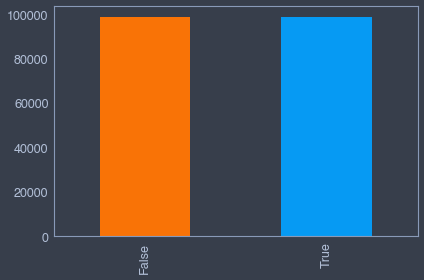

In [23]:
# create target label
df_cleaned['target'] = pos_class_mask

# add positive and negative classes together
df_concat = pd.concat([df_cleaned[neg_class].sample(updated_class_size), df_cleaned[pos_class_mask]], axis=0)
display(df_concat.groupby('target').describe()['score'])

# plot target distribution to validate
df_concat['target'].value_counts().plot(kind='bar', color=['xkcd:orange', 'xkcd:azure'])
plt.grid(False)
save_fig('class distribution after cleaning')

In [24]:
# get training size from parameters
training_size = int(len(df_concat)*TRAIN_SIZE)

# shuffle 
df_concat_shuffled = df_concat.sample(len(df_concat))

# fill na values with a blank
df_concat_shuffled['selftext'] = df_concat_shuffled['selftext'].fillna(value='')

# generate train and test sets
train = df_concat_shuffled[:training_size]
test = df_concat_shuffled[training_size:]
print(train.shape, test.shape)

(195346, 15) (1974, 15)


In [25]:
# some useful boolean masks
is_funny = train['target'] == True

# examples of funny jokes
train[train['score'] >= train['score'].mean()][['title', 'selftext', 'score']].sample(10)

,title,selftext,score
821137,I was in a job interview today when the manager handed me his laptop and said...,"""I want you to try and sell this to me."" So I put it under my arm, walked out of the building and went home. Eventually he called my mobile and said, ""Bring it back here right now!"" I said, ""$200 and it's yours.""",20360
123610,What do you call a company that replants fields of grass using cropduster airplanes?,A re-seeding airline! This joke sucks but it's my cakeday and I was told there would be plentiful imaginary internet points .... XD,3986
307809,Why don't you see brown envelopes in the mail anymore?,Because everyone knows white mails get through the system faster.,2557
970463,The worst part about online dating,"is when the girl lists her weight as 115lbs, but when you're lifting her to put her in your trunk, she's obviously well over 140.",613
847315,What does a clock do when it's hungry?,It goes back 4 seconds,883
634205,Two days into my diet I removed all the junk food from my house....,.....and it was delicious,1797
17425,Teslas dont have that new car smell.,They come with that Elon Musk.,5870
949708,My wife asked me why I carry a gun around the house.,"""To fight the Decepticons,"" I said. She laughed. I laughed. The toaster laughed. I shot the toaster.",5269
123623,"A woman asked me, What does equality mean?","I said, Your guess is as good as mine.",823
179628,"When I was little, I had a disease that required me to eat dirt three times a day in order to survive..",It's a good thing my older brother told me about it.,19406


In [39]:
# examples of not funny jokes
train[~is_funny][['title', 'selftext', 'score']].sample(10)

,title,selftext,score
175779,Why did so many black men get killed in Vietnam?,"When the generals would yell, ""Get down!"" they would all start dancing.",0
515122,i hacked the powerball,why do you think the previous winner was the winner? duh. i gave him the numbers,0
579861,What is Boko Haram's favorite Movie?,"Honey, I Blew Up the Kid",0
901201,The Ghetto Finger Family Song,"Daddy finger, daddy finger, where are you? ... ... ...Daddy?",0
144614,My daughter told me she wants to be a veterinarian today.,"I told her she can join the military if she wants to be a vet, less PTSD.",0
597185,My mom is really good at folding...,But I'm not! She can fold those weird bedsheets perfectly! But I can't even wash my pants right. My sister can though... maybe I didn't get the right jeans.,0
700261,What do Pizzas parents have in common?,"If they're black, you have nothing to eat.",0
914063,Q: Why is air a lot like sex?,A: Because it's no big deal unless you're not getting any.,0
923113,"""Great, now we're looking at luggage. Not like we need more luggage.""","Me, 11/25/2015",0
638419,Why are polar bears going extinct?,Because they are polar and are being dissolved in ocean water.,0


Saving figure density plot of log title length


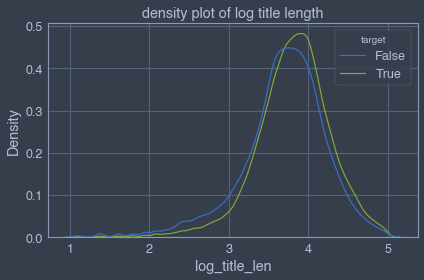

Saving figure density plot of log selftext length


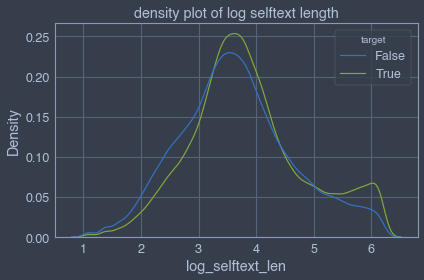

In [27]:
# plots of length
train['log_title_len'] = np.log(train['title_len'])
train['log_selftext_len'] = np.log(train['selftext_len'])

funny_df = train[train['target'] == True]
not_funny_df = train[train['target'] == False]

# plots lengths
sns.kdeplot(x='log_title_len', data=train, hue='target')
plt.title('density plot of log title length')
save_fig('density plot of log title length')
plt.show()
train['log_selftext_len'] = np.log(train['selftext_len'])
sns.kdeplot(x='log_selftext_len', data=train, hue='target')
plt.title('density plot of log selftext length')
save_fig('density plot of log selftext length')
plt.show()

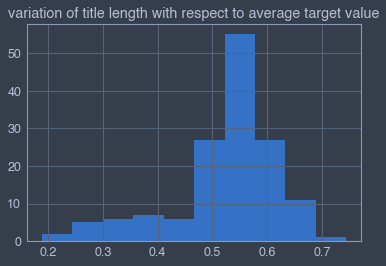

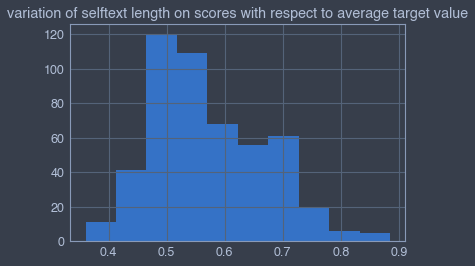

In [28]:
# histograms of string lengths w.r.t. whether or not a joke is classified as funny or not funny
train.groupby(['title_len']).mean()['target'].hist()
plt.title('variation of title length with respect to average target value')
plt.show()
train.groupby(['selftext_len']).mean()['target'].hist()
plt.title('variation of selftext length on scores with respect to average target value')
plt.show()

### Time Series-Data

Saving figure submissions over time


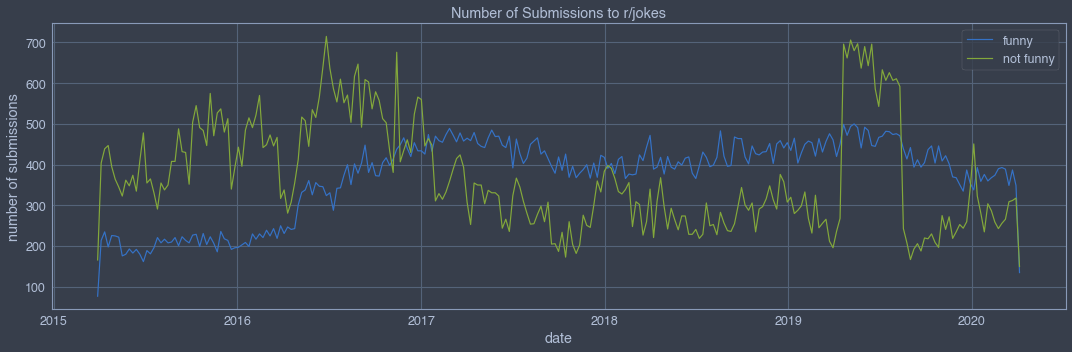

In [32]:
# making unix created_times into readable timestamps to examine timeseries data
train['created_at'] = train['created_utc'].apply(lambda x: make_timestamp(x))
#train[['created_at', 'title', 'selftext', 'target']].head()

# create dataframes with with timestamp as index for examination
df_funny = train[is_funny].reset_index(drop=False).set_index('created_at').sort_index()
df_not_funny = train[~is_funny].reset_index(drop=False).set_index('created_at').sort_index()

# plot submissions over time
plt.figure(figsize=(15, 5))

sns.lineplot(x=df_funny.resample('W').count().index, y='type', data=df_funny.resample('W').count(), label='funny')
sns.lineplot(x=df_not_funny.resample('W').count().index, y='type', data=df_not_funny.resample('W').count(), label='not funny')
plt.title('Number of Submissions to r/jokes')
plt.xlabel('date')
plt.ylabel('number of submissions')
plt.legend()
save_fig('submissions over time')
plt.show()

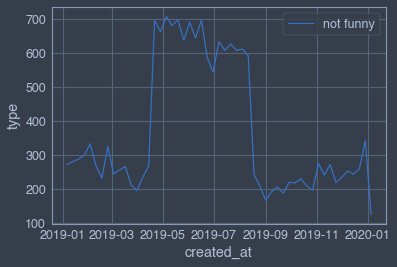

anomaly starts at 2019-04-07 00:00:00 and ends at 2019-09-01 00:00:00


In [33]:
# taking another look at that odd event in 2019
sns.lineplot(x=df_not_funny.loc['2019'].resample('W').count().index, y='type', data=df_not_funny.loc['2019'].resample('W').count(), label='not funny')
plt.show()

# find the start and end-points for the anomaly
not_funny_2019_counts = df_not_funny.loc['2019'].resample('W').count()
start_date = not_funny_2019_counts['2019-04':'2019-05'][not_funny_2019_counts['id']['2019-04':'2019-05'] == not_funny_2019_counts['id']['2019-04':'2019-05'].min()].index[0]
end_date = not_funny_2019_counts[start_date:"2019-12-01"][not_funny_2019_counts[start_date:"2019-12-01"]['id'] == not_funny_2019_counts[start_date:"2019-12-01"]['id'].min()].index[0]
start_date_not_funny_event, end_date_not_funny_event = str(start_date), str(end_date)
print(f"anomaly starts at {start_date_not_funny_event} and ends at {end_date_not_funny_event}")

Saving figure average submission per hour


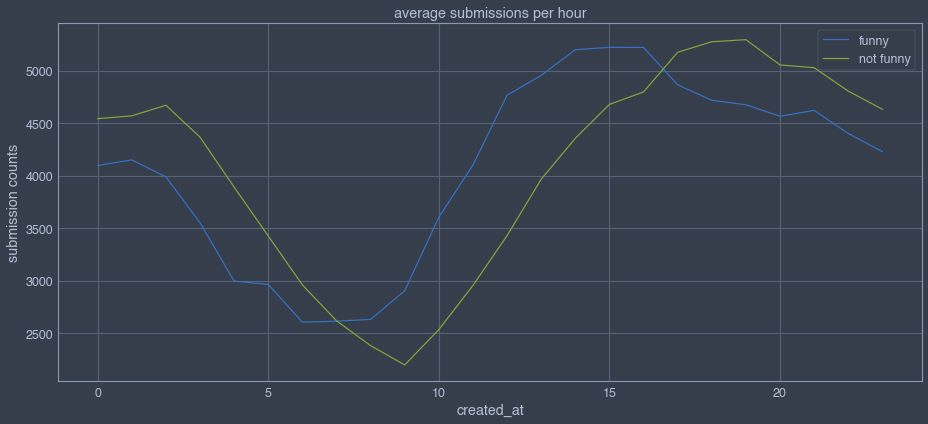

In [30]:
# average periods
plt.figure(figsize=(13, 6))
sns.lineplot(data = df_funny.groupby(df_funny.index.hour)['target'].count(), label='funny')
sns.lineplot(data = df_not_funny.groupby(df_not_funny.index.hour)['target'].count(), label='not funny', )
plt.title('average submissions per hour')
plt.ylabel('submission counts')
save_fig('average submission per hour')
plt.show()

In [31]:
# dataframe containing samples from the anomaly
not_funny_anom_df = df_not_funny.loc[start_date_not_funny_event:end_date_not_funny_event]

# get indexing for slicing
anomaly_idx = not_funny_anom_df.set_index('index').index
norm_idx = list(set(df_not_funny.set_index('index').index) - set(anomaly_idx))

# dataframe containing samples not in the anomaly
not_funny_norm_df = df_not_funny.set_index('index').loc[norm_idx]